In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.fpm import FPGrowth
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

In [4]:
import pyspark.sql.functions as f

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
spark = SparkSession.builder.appName('kmeans_demo').getOrCreate()

In [6]:
# Loads data.
data = spark.read.csv("Cung cap du lieu buoi 8/5000_points.txt", header=False,
                      inferSchema=True, sep="\t")

In [8]:
data.show(3)

+------+------+
|   _c0|   _c1|
+------+------+
|664159|550946|
|665845|557965|
|597173|575538|
+------+------+
only showing top 3 rows



In [9]:
data.count()

5000

In [10]:
data.describe().show()

+-------+------------------+------------------+
|summary|               _c0|               _c1|
+-------+------------------+------------------+
|  count|              5000|              5000|
|   mean|       514937.5566|       494709.2928|
| stddev|244465.90192584388|235840.85296943647|
|    min|             19835|             51121|
|    max|            961951|            970756|
+-------+------------------+------------------+



In [11]:
data = data.select(col('_c0').alias('x'), col('_c1').alias('y'))

In [12]:
data.show(3)

+------+------+
|     x|     y|
+------+------+
|664159|550946|
|665845|557965|
|597173|575538|
+------+------+
only showing top 3 rows



In [13]:
data.columns

['x', 'y']

In [14]:
vec_assembler = VectorAssembler(inputCols = data.columns, outputCol = 'features')

In [15]:
final_data = vec_assembler.transform(data)

In [17]:
final_data.show(3)

+------+------+-------------------+
|     x|     y|           features|
+------+------+-------------------+
|664159|550946|[664159.0,550946.0]|
|665845|557965|[665845.0,557965.0]|
|597173|575538|[597173.0,575538.0]|
+------+------+-------------------+
only showing top 3 rows



In [18]:
scaler = StandardScaler(inputCol = 'features', outputCol = 'scaledFeatures',
                       withStd = True, withMean = False)  

In [19]:
# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)

In [20]:
# Normalize each feature to have unit standard deviation
final_data = scalerModel.transform(final_data)

In [21]:
final_data.show(3, False)

+------+------+-------------------+---------------------------------------+
|x     |y     |features           |scaledFeatures                         |
+------+------+-------------------+---------------------------------------+
|664159|550946|[664159.0,550946.0]|[2.716775610700365,2.336092297255214]  |
|665845|557965|[665845.0,557965.0]|[2.7236722780340017,2.3658538924649704]|
|597173|575538|[597173.0,575538.0]|[2.4427660270639544,2.440366004250274] |
+------+------+-------------------+---------------------------------------+
only showing top 3 rows



In [22]:
# Trains a k-means model
k_list = []
wsse_list = []
for k in range(2, 11):
    # kmeans = KMeans(featuresCol='features', k=k)
    kmeans = KMeans(featuresCol = 'scaledFeatures', k = k)
    model = kmeans.fit(final_data)
    wsse = model.computeCost(final_data)
    k_list.append(k)
    wsse_list.append(wsse)
    print('With k = ', k, 'Set Sum of Squared Errors = ' + str(wsse))

With k =  2 Set Sum of Squared Errors = 6378.971476210267
With k =  3 Set Sum of Squared Errors = 3706.746994293558
With k =  4 Set Sum of Squared Errors = 2522.798713630235
With k =  5 Set Sum of Squared Errors = 2207.225583241723
With k =  6 Set Sum of Squared Errors = 1428.5520316461884
With k =  7 Set Sum of Squared Errors = 1188.07804401527
With k =  8 Set Sum of Squared Errors = 1016.2898019604785
With k =  9 Set Sum of Squared Errors = 741.0235336377161
With k =  10 Set Sum of Squared Errors = 638.0150940837309


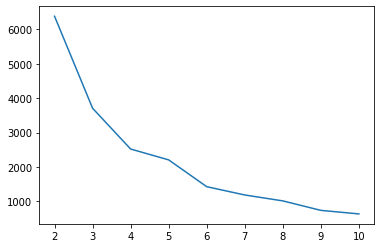

In [24]:
plt.plot(k_list, wsse_list)
plt.show()
# k = 6

In [28]:
# Trains a k=means model
kmeans = KMeans(featuresCol='scaledFeatures', k=6)
model = kmeans.fit(final_data)

In [29]:
# Evaluate clustering by computing Within Set Sum of Squared Errors
wsse = model.computeCost(final_data)
print('Within Set Sum of Squared Errors = ' + str(wsse))

Within Set Sum of Squared Errors = 1428.5520316461884


In [30]:
# Shows the result.
centers = model.clusterCenters()
print('Cluster Centers: ')
for center in centers:
    print(center)

Cluster Centers: 
[1.69943273 0.73022552]
[3.38640428 1.01829978]
[1.3483211  3.47165316]
[1.03803271 1.99583831]
[2.47846649 2.01575062]
[3.19901881 3.03633073]


In [31]:
predictions = model.transform(final_data)

In [32]:
predictions.select('prediction').show(5)

+----------+
|prediction|
+----------+
|         4|
|         4|
|         4|
|         4|
|         4|
+----------+
only showing top 5 rows



In [33]:
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  649|
|         3| 1304|
|         5| 1006|
|         4|  675|
|         2|  661|
|         0|  705|
+----------+-----+



In [34]:
final_data.show(3, False)

+------+------+-------------------+---------------------------------------+
|x     |y     |features           |scaledFeatures                         |
+------+------+-------------------+---------------------------------------+
|664159|550946|[664159.0,550946.0]|[2.716775610700365,2.336092297255214]  |
|665845|557965|[665845.0,557965.0]|[2.7236722780340017,2.3658538924649704]|
|597173|575538|[597173.0,575538.0]|[2.4427660270639544,2.440366004250274] |
+------+------+-------------------+---------------------------------------+
only showing top 3 rows



In [35]:
temp = final_data.select('scaledFeatures').rdd.map(lambda x: x[0].toArray().tolist()).toDF()

In [37]:
temp.show(3)

+------------------+------------------+
|                _1|                _2|
+------------------+------------------+
| 2.716775610700365| 2.336092297255214|
|2.7236722780340017|2.3658538924649704|
|2.4427660270639544| 2.440366004250274|
+------------------+------------------+
only showing top 3 rows



In [38]:
data_result = predictions.select('prediction')
data_result.columns

['prediction']

In [39]:
temp = temp.withColumn('row_index', f.monotonically_increasing_id())
data_result = data_result.withColumn('row_index', f.monotonically_increasing_id())
temp = temp.join(data_result, on = ['row_index']).sort('row_index').drop('row_index')

In [40]:
temp.show(3)

+------------------+------------------+----------+
|                _1|                _2|prediction|
+------------------+------------------+----------+
| 2.716775610700365| 2.336092297255214|         4|
|2.7236722780340017|2.3658538924649704|         4|
|2.4427660270639544| 2.440366004250274|         4|
+------------------+------------------+----------+
only showing top 3 rows



In [41]:
temp = temp.select(col('_1').alias('x_scale'), col('_2').alias('y_scale'), 'prediction')

In [42]:
df = temp.toPandas

In [44]:
centers_df = pd.DataFrame(centers)
centers_df.head()

,0,1
0,1.699433,0.730226
1,3.386404,1.018300
2,1.348321,3.471653
3,1.038033,1.995838
4,2.478466,2.015751


In [56]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x = 'x_scale', y = 'y_scale', data = df)
plt.show()

AttributeError: 'function' object has no attribute 'get'

<Figure size 864x576 with 0 Axes>

In [54]:
# Visualizing
plt.figure(figsize=(12, 8))
sns.scatterplot(x = 'x_scale', y = 'y_scale', data = df, 
               #hue = 'prediction',
               # size = 'prediction',
               palette = 'Set1') 
sns.scatterplot(data = centers_df, x = 0, y = 1, color = 'black', marker= 'x')
plt.show()

AttributeError: 'function' object has no attribute 'get'

<Figure size 864x576 with 0 Axes>